# Step 0. 탠서플로우 및 데이터셋 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

# Step 1. tf_flowers 데이터셋 내려받기

- train_data : 80%   
- validation_data : 10%   
- test_data : 10% 

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',  # instead of 'cats_vs_dogs' 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Step 2. 이미지 통일, 데이터셋 준비

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32) 
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)   

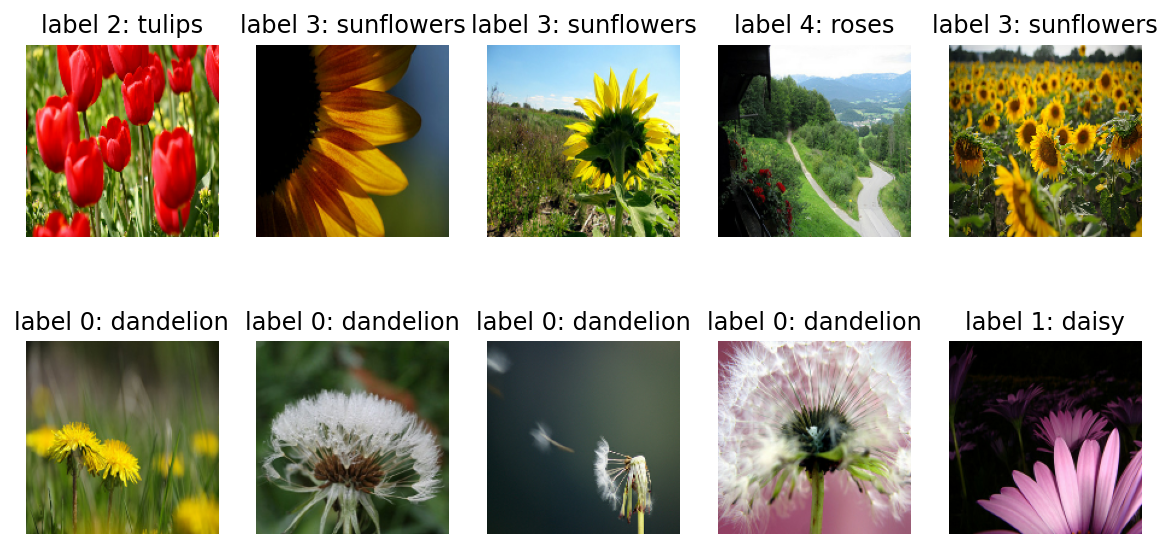

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# Step3 . 모델 설계하기

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [12]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')   
    ]) 
    

# Step4 . 모델 학습시키기

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [15]:
BATCH_SIZE = 32 
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
validation_steps = 10
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0)) 
print("initial accuracy: {:.2f}".format(accuracy0)) 

10/10 [==============================] - 0s 12ms/step - loss: 1.6171 - accuracy: 0.2031
initial loss: 1.62
initial accuracy: 0.20


In [18]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 21s 226ms/step - loss: 1.4083 - accuracy: 0.4036 - val_loss: 1.1502 - val_accuracy: 0.5204
Epoch 2/10
92/92 [==============================] - 2s 27ms/step - loss: 1.0833 - accuracy: 0.5579 - val_loss: 1.0322 - val_accuracy: 0.5886
Epoch 3/10
92/92 [==============================] - 2s 26ms/step - loss: 0.9379 - accuracy: 0.6328 - val_loss: 1.1164 - val_accuracy: 0.5368
Epoch 4/10
92/92 [==============================] - 2s 26ms/step - loss: 0.8419 - accuracy: 0.6897 - val_loss: 1.0256 - val_accuracy: 0.5967
Epoch 5/10
92/92 [==============================] - 2s 26ms/step - loss: 0.7448 - accuracy: 0.7255 - val_loss: 0.9734 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 2s 27ms/step - loss: 0.6585 - accuracy: 0.7599 - val_loss: 0.9461 - val_accuracy: 0.6621
Epoch 7/10
92/92 [==============================] - 2s 26ms/step - loss: 0.5804 - accuracy: 0.7943 - val_loss: 0.9694 - val_accuracy: 0.6322
Epoch 8/10


# Step5 . 모델 평가해보기
- 직접 만든 모델은 정확도는 낮고, overfitting 또한 높았다.
- 이러한 단점을 보완하기 위해 아래에서 VGG16 모델을 사용해 볼 것이다.

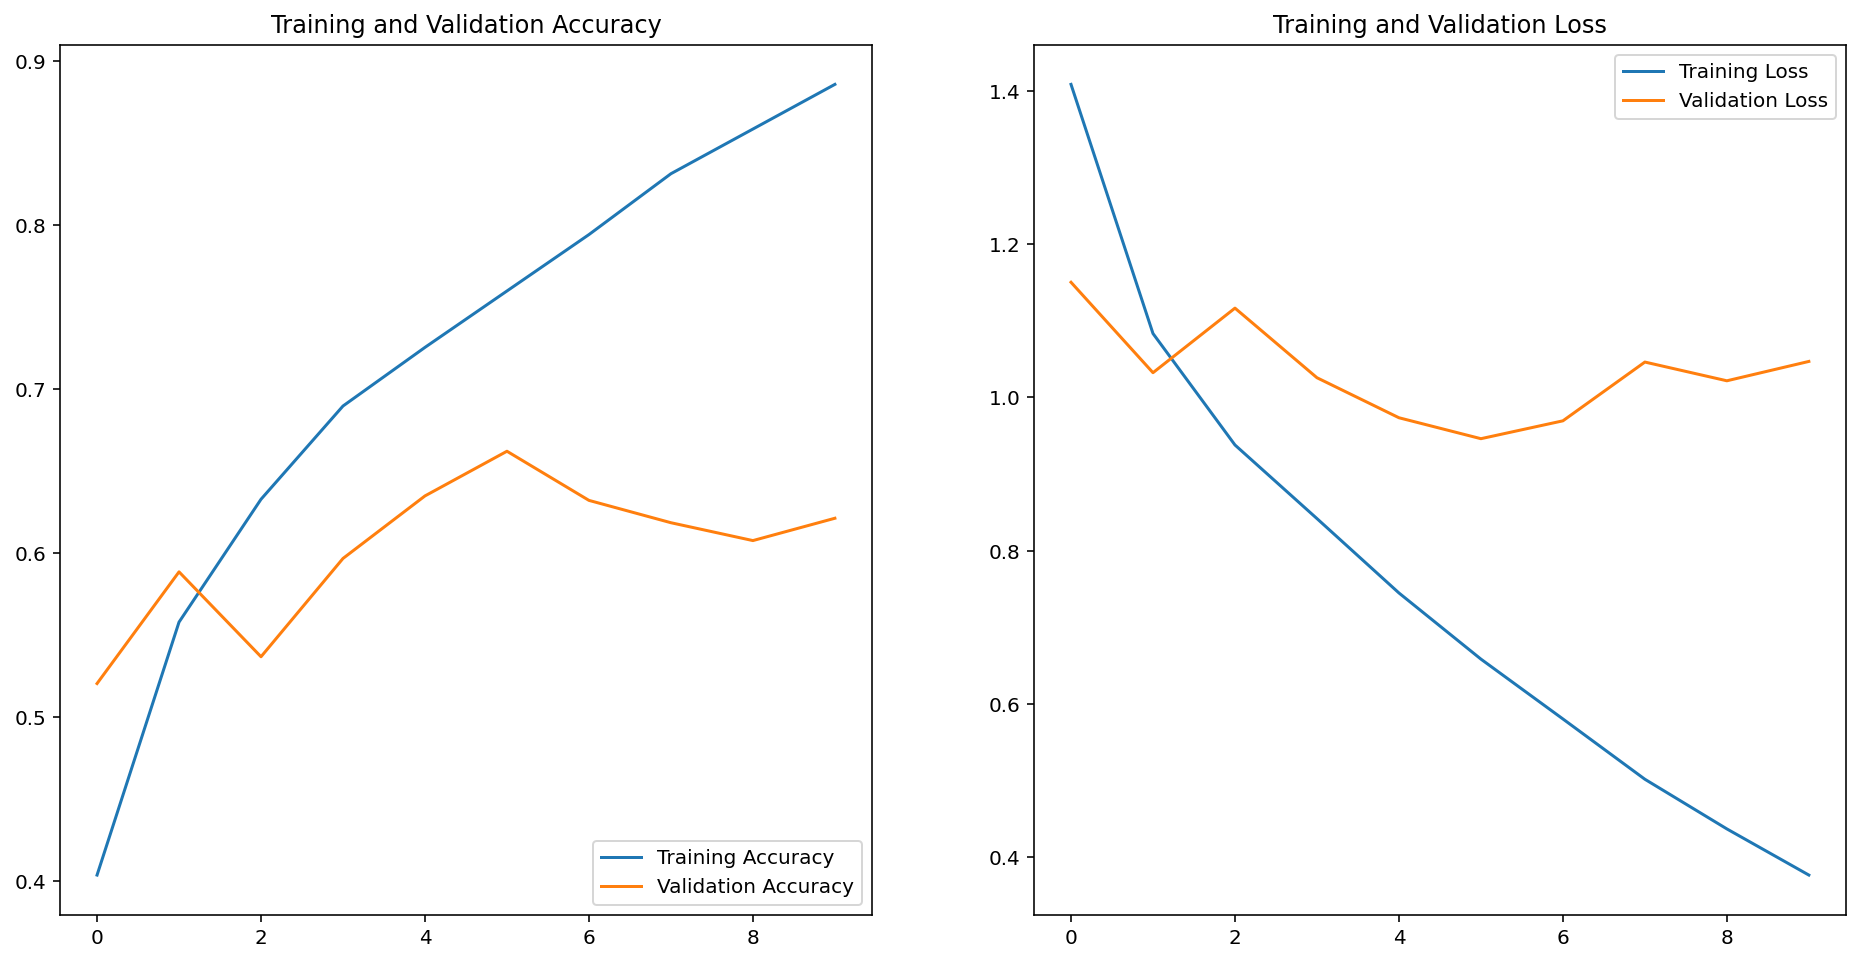

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.03466158e-03, 4.62954352e-03, 7.98982918e-01, 1.10057920e-01,
        7.72949606e-02],
       [8.06304097e-01, 1.75466016e-01, 1.46166626e-02, 7.86286328e-05,
        3.53459269e-03],
       [2.83875197e-01, 4.13067527e-02, 3.54152352e-01, 3.19111913e-01,
        1.55376887e-03],
       [6.84034303e-02, 2.81836361e-01, 5.65303802e-01, 8.58400017e-03,
        7.58724213e-02],
       [6.78720713e-01, 1.02266535e-01, 9.36976299e-02, 2.41920706e-02,
        1.01123057e-01],
       [2.05730826e-01, 4.65319395e-01, 3.11664701e-01, 2.36282661e-03,
        1.49222771e-02],
       [6.26805355e-04, 1.91404462e-01, 8.01480412e-01, 1.51647639e-03,
        4.97193402e-03],
       [4.08716835e-02, 2.67457604e-01, 4.55012023e-01, 1.42113026e-02,
        2.22447410e-01],
       [6.42321585e-03, 1.62508819e-04, 5.72270378e-02, 9.36052203e-01,
        1.34978531e-04],
       [9.87044036e-01, 9.83542856e-03, 1.27141282e-03, 1.92129628e-05,
        1.82977598e-03],
       [9.85480487e-01, 7.9610

In [25]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 2, 2, 0, 1, 2, 2, 3, 0, 0, 3, 3, 2, 0, 3, 2, 0, 0, 2, 2, 0,
       2, 0, 1, 2, 2, 1, 2, 1, 0, 0])

In [27]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    # [[YOUR CODE]]
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)    # 약 70% 내외

56.25


# Step4,5 VGG16 Models

In [28]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [29]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [30]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [33]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [34]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


In [35]:
base_model.trainable = False

In [36]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [39]:
validation_steps=10
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 1s 52ms/step - loss: 1.6391 - accuracy: 0.2469
initial loss: 1.64
initial accuracy: 0.25


## EPOCHS = 10 일 때 약 test accuracy = 0.83%가 나왔다

In [40]:
EPOCHS = 10   

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 54s 586ms/step - loss: 1.3413 - accuracy: 0.5460 - val_loss: 1.1258 - val_accuracy: 0.6948
Epoch 2/10
92/92 [==============================] - 7s 74ms/step - loss: 1.0260 - accuracy: 0.6989 - val_loss: 0.9005 - val_accuracy: 0.7221
Epoch 3/10
92/92 [==============================] - 7s 74ms/step - loss: 0.8559 - accuracy: 0.7452 - val_loss: 0.7766 - val_accuracy: 0.7493
Epoch 4/10
92/92 [==============================] - 7s 75ms/step - loss: 0.7541 - accuracy: 0.7616 - val_loss: 0.7017 - val_accuracy: 0.7493
Epoch 5/10
92/92 [==============================] - 7s 75ms/step - loss: 0.6879 - accuracy: 0.7871 - val_loss: 0.6711 - val_accuracy: 0.7711
Epoch 6/10
92/92 [==============================] - 7s 75ms/step - loss: 0.6380 - accuracy: 0.7960 - val_loss: 0.6341 - val_accuracy: 0.7711
Epoch 7/10
92/92 [==============================] - 7s 75ms/step - loss: 0.6016 - accuracy: 0.8089 - val_loss: 0.6037 - val_accuracy: 0.7929
Epoch 8/10


## 목표치인 85%를 위해 epochs 를 늘려보겠다
- test accuracy = 약 86%
- val_ accuracy = 약 84% 의 결과값을 얻었다!

In [53]:
EPOCHS = 10   

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 7s 74ms/step - loss: 0.5099 - accuracy: 0.8328 - val_loss: 0.5327 - val_accuracy: 0.8174
Epoch 2/10
92/92 [==============================] - 7s 74ms/step - loss: 0.4950 - accuracy: 0.8386 - val_loss: 0.5235 - val_accuracy: 0.8256
Epoch 3/10
92/92 [==============================] - 7s 74ms/step - loss: 0.4801 - accuracy: 0.8450 - val_loss: 0.5278 - val_accuracy: 0.8120
Epoch 4/10
92/92 [==============================] - 7s 74ms/step - loss: 0.4708 - accuracy: 0.8454 - val_loss: 0.5211 - val_accuracy: 0.8120
Epoch 5/10
92/92 [==============================] - 7s 74ms/step - loss: 0.4585 - accuracy: 0.8505 - val_loss: 0.5216 - val_accuracy: 0.8147
Epoch 6/10
92/92 [==============================] - 7s 74ms/step - loss: 0.4476 - accuracy: 0.8573 - val_loss: 0.4957 - val_accuracy: 0.8283
Epoch 7/10
92/92 [==============================] - 7s 74ms/step - loss: 0.4383 - accuracy: 0.8566 - val_loss: 0.4932 - val_accuracy: 0.8283
Epoch 8/10
92

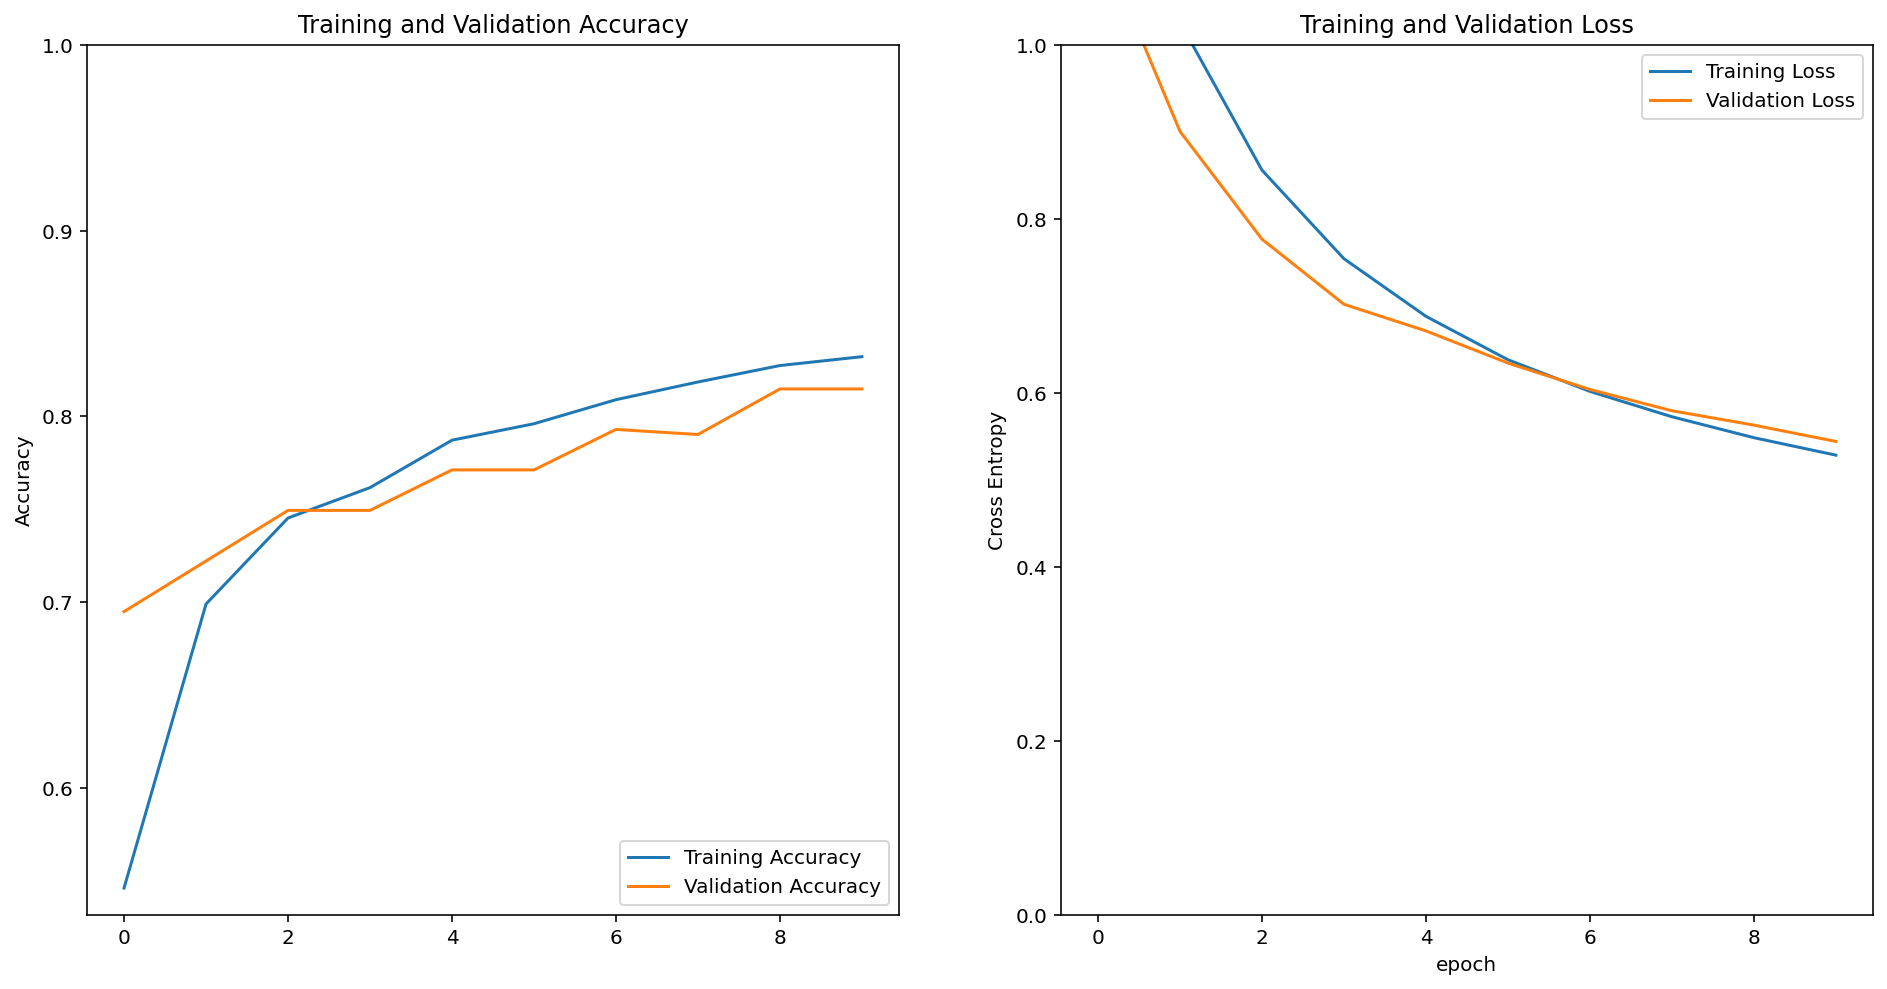

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.80806459e-02, 7.65565112e-02, 7.13309228e-01, 6.49905428e-02,
        1.17063105e-01],
       [9.98751044e-01, 9.32901050e-04, 2.16579811e-05, 1.16763025e-04,
        1.77527763e-04],
       [7.15714157e-01, 1.16485864e-01, 2.83592455e-02, 1.11246206e-01,
        2.81944908e-02],
       [4.26231744e-03, 1.78851262e-02, 5.74576139e-01, 1.40151270e-02,
        3.89261246e-01],
       [6.74733937e-01, 2.57424980e-01, 2.04741396e-02, 1.94345415e-02,
        2.79323962e-02],
       [9.17418420e-01, 4.65626493e-02, 7.51557294e-03, 2.58713532e-02,
        2.63212365e-03],
       [1.90465469e-02, 1.98961329e-02, 6.94025576e-01, 1.75571188e-01,
        9.14605707e-02],
       [3.70389223e-01, 4.47881967e-01, 3.59367416e-03, 1.70669377e-01,
        7.46576348e-03],
       [1.12364758e-02, 3.23611870e-03, 3.53854783e-02, 8.77842247e-01,
        7.22996518e-02],
       [9.99272406e-01, 6.35807344e-04, 3.00580791e-06, 8.07091928e-05,
        8.04520187e-06],
       [9.67941523e-01, 2.4592

In [43]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 2, 4, 4, 3, 0, 4])

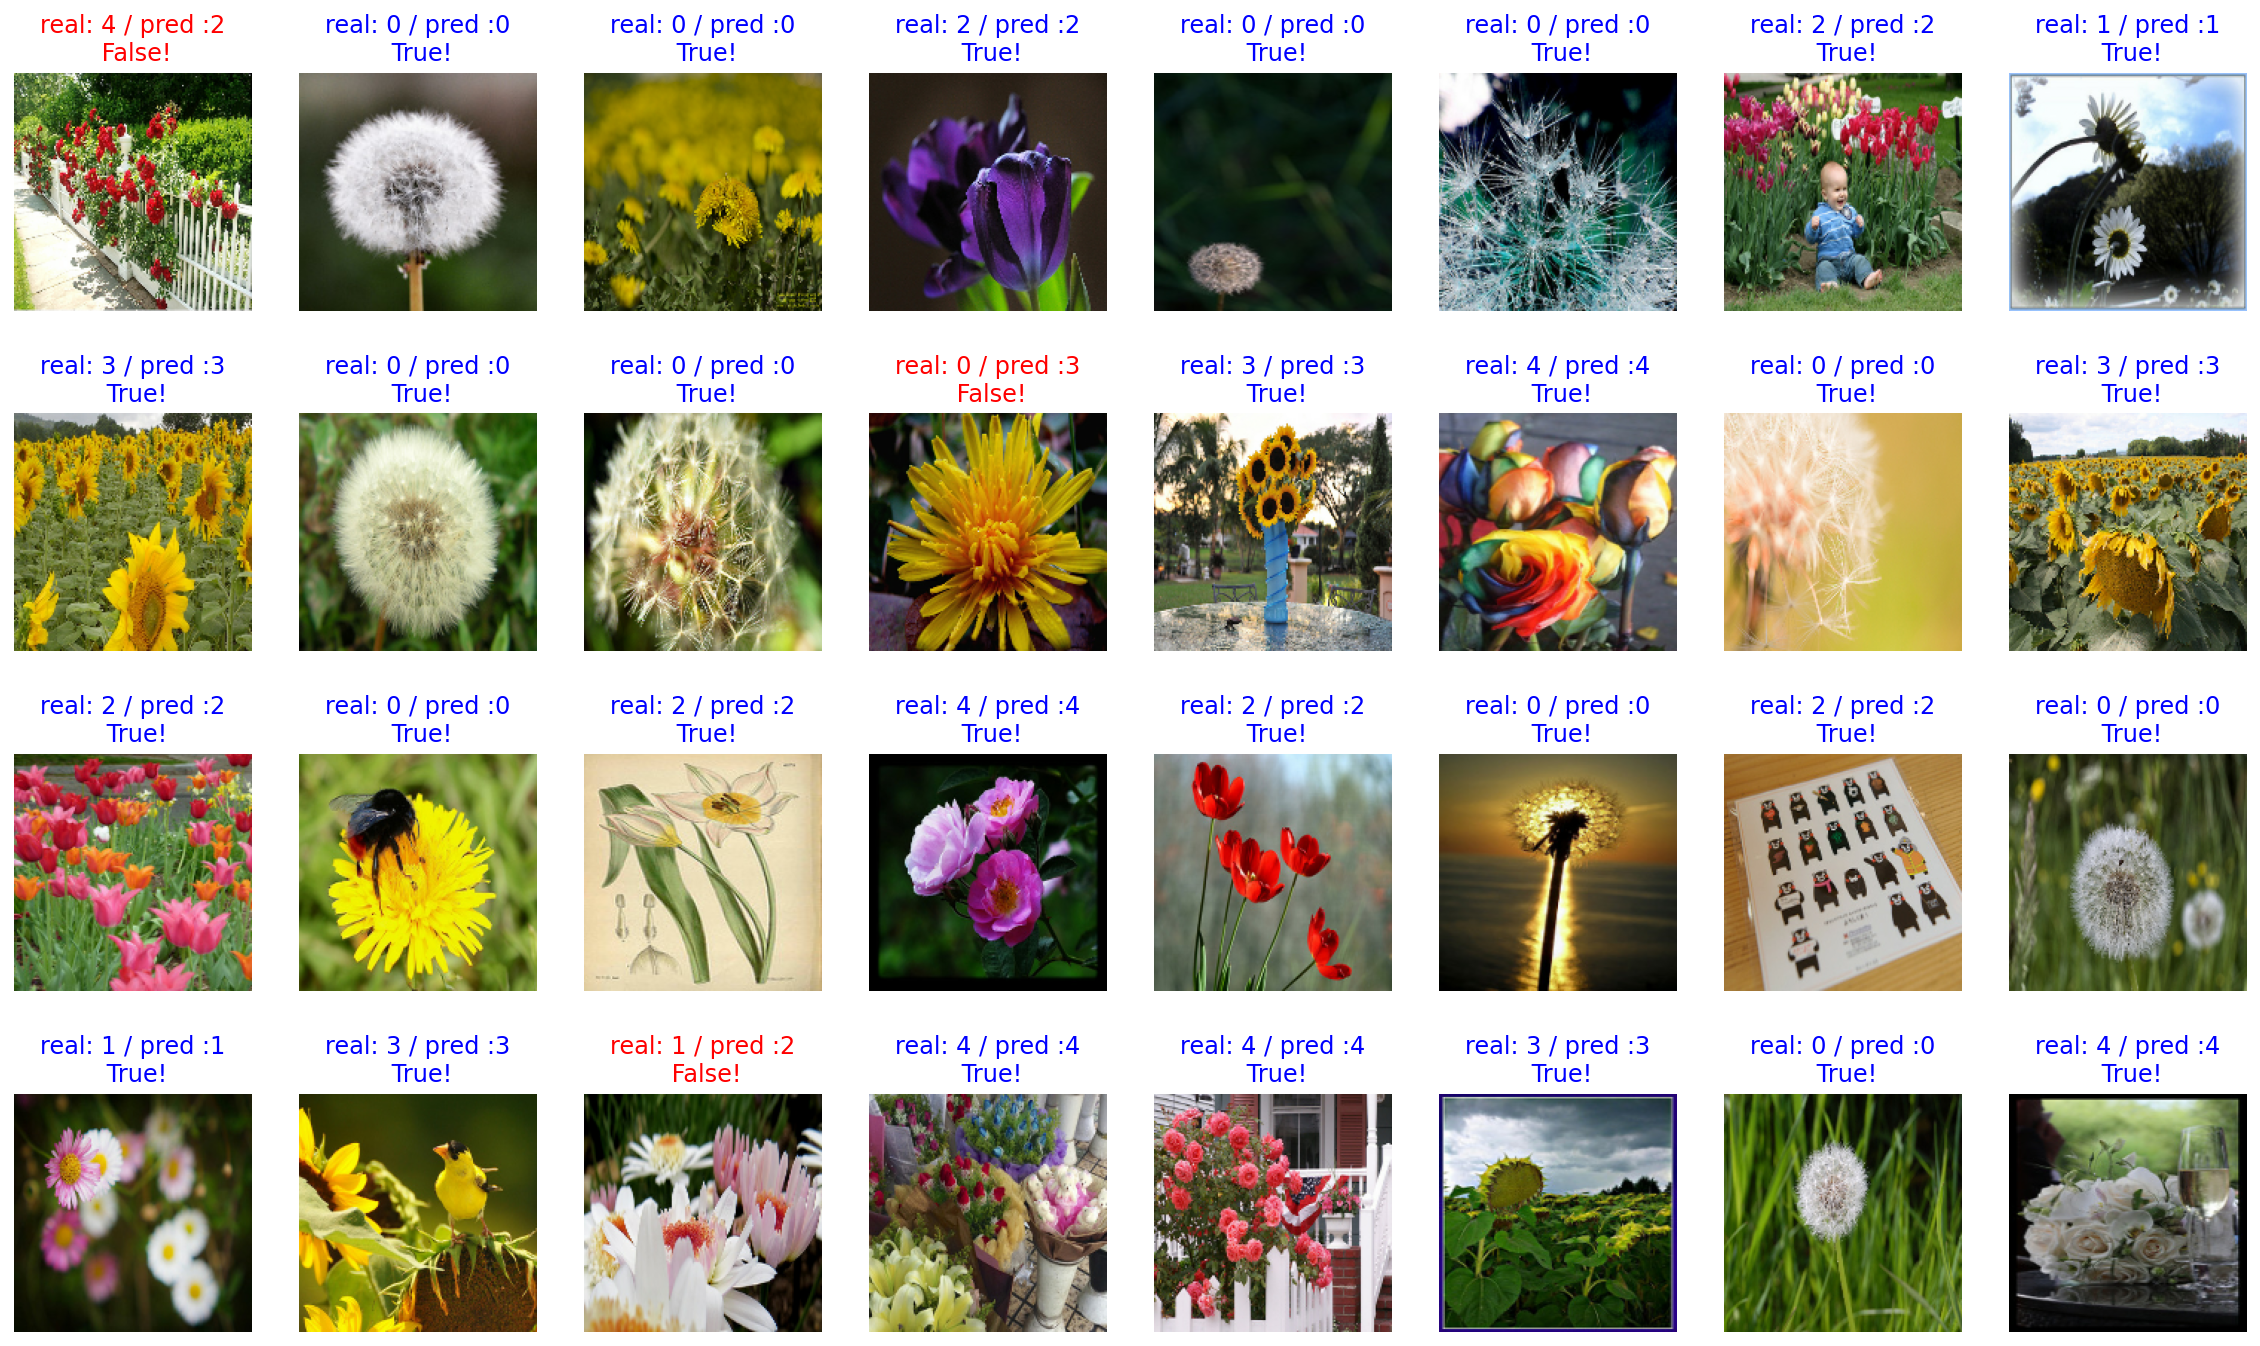

In [44]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [45]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

90.625


In [46]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/tf_flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [47]:
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers/images"
os.path.exists(img_dir_path)

True

In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 이미지 파일 분류 함수 선언

In [49]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    flower0_percentage = round(prediction[0] * 100)
    flower1_percentage = round(prediction[1] * 100)
    flower2_percentage = round(prediction[2] * 100)
    flower3_percentage = round(prediction[3] * 100)
    flower4_percentage = round(prediction[4] * 100)
    print(f"This image seems {flower0_percentage}% dandelion,and {flower1_percentage}% daisy, and {flower2_percentage}% tulips,and {flower3_percentage}% sunflower. and {flower4_percentage}% roses.")

# 번외 : 구글링을 통해 임의의 사진들을 위의 분류 함수로 분류해보았다

- 구글의 이미지들이 선명하고 명확해서인지 모두 정답률 100%로 분류해 내었다!   
- 분류모델이 아닌 이미지를 넣었을 때  코스모스는 sunflower로, 벚꽃은 rose로 분류했다  

This image seems 0.0% dandelion,and 0.0% daisy, and 0.0% tulips,and 100.0% sunflower. and 0.0% roses.


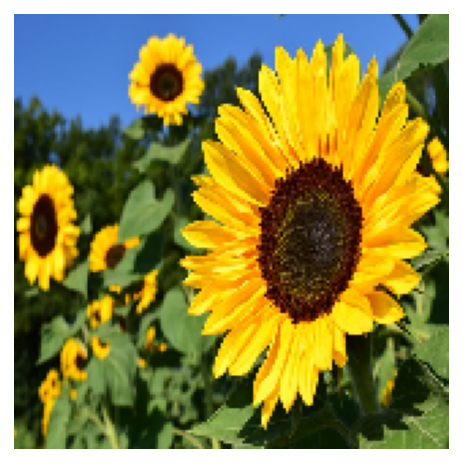

In [50]:
filename = 'flower3.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion,and 0.0% daisy, and 0.0% tulips,and 0.0% sunflower. and 100.0% roses.


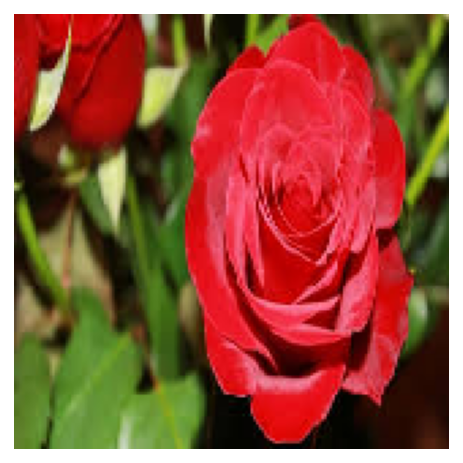

In [51]:
filename = 'flower4.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion,and 0.0% daisy, and 100.0% tulips,and 0.0% sunflower. and 0.0% roses.


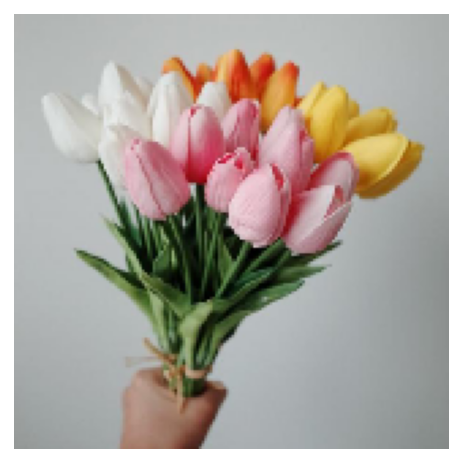

In [54]:
filename = '튤립.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 100.0% dandelion,and 0.0% daisy, and 0.0% tulips,and 0.0% sunflower. and 0.0% roses.


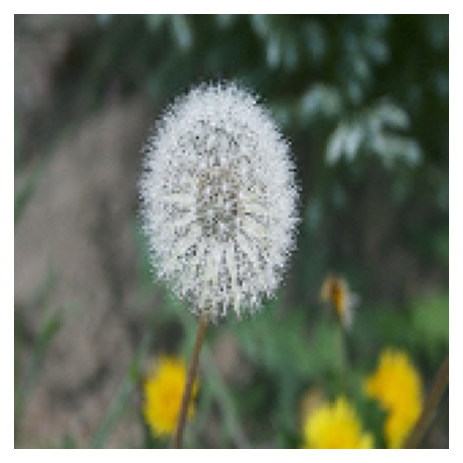

In [56]:
filename = '민들레.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion,and 100.0% daisy, and 0.0% tulips,and 0.0% sunflower. and 0.0% roses.


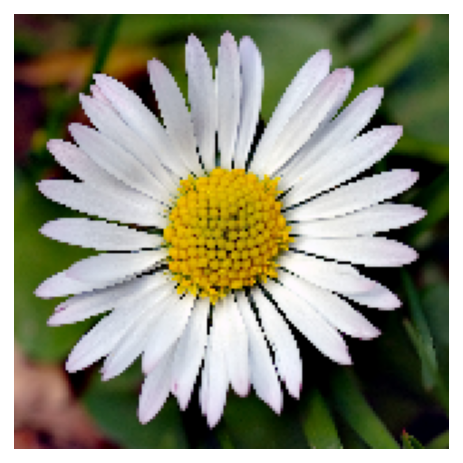

In [57]:
filename = '데이지.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion,and 0.0% daisy, and 0.0% tulips,and 100.0% sunflower. and 0.0% roses.


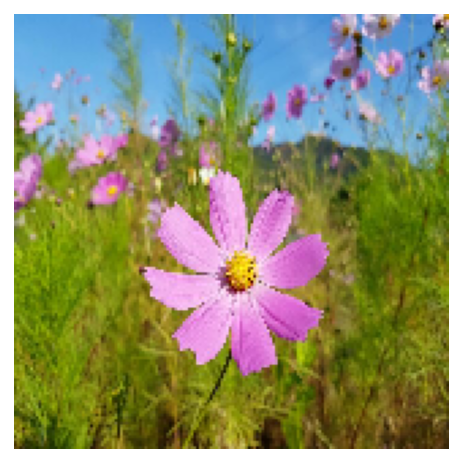

In [66]:
filename = '코스모스.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion,and 0.0% daisy, and 0.0% tulips,and 0.0% sunflower. and 100.0% roses.


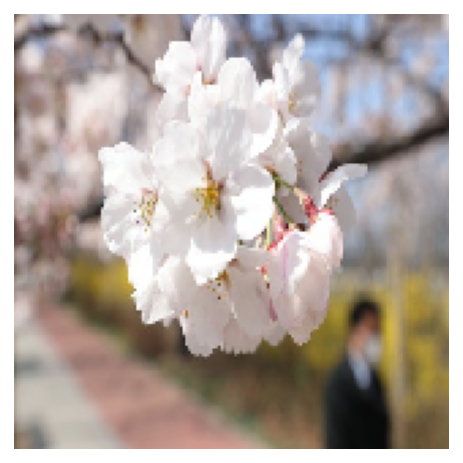

In [67]:
filename = '벚꽃.jpg'

show_and_predict_image(img_dir_path, filename)

# 번외2 : 학습 방식 바꿔보기 : Adam   
- 위에서 RMSProp 방식으로 학습시켰다.   
- 이번에는 개선된 방식인 Adam 방식으로 결과가 어떨지 확인해 보겠다.

In [58]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

## RMSProp 방식에 비해 정확도가 89%로 높았다. 

In [60]:
EPOCHS = 10   

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 7s 75ms/step - loss: 0.4047 - accuracy: 0.8723 - val_loss: 0.4754 - val_accuracy: 0.8365
Epoch 2/10
92/92 [==============================] - 7s 75ms/step - loss: 0.3973 - accuracy: 0.8736 - val_loss: 0.4709 - val_accuracy: 0.8420
Epoch 3/10
92/92 [==============================] - 7s 73ms/step - loss: 0.3902 - accuracy: 0.8743 - val_loss: 0.4630 - val_accuracy: 0.8420
Epoch 4/10
92/92 [==============================] - 7s 73ms/step - loss: 0.3796 - accuracy: 0.8794 - val_loss: 0.4650 - val_accuracy: 0.8365
Epoch 5/10
92/92 [==============================] - 7s 74ms/step - loss: 0.3767 - accuracy: 0.8787 - val_loss: 0.4647 - val_accuracy: 0.8365
Epoch 6/10
92/92 [==============================] - 7s 74ms/step - loss: 0.3693 - accuracy: 0.8852 - val_loss: 0.4612 - val_accuracy: 0.8501
Epoch 7/10
92/92 [==============================] - 7s 80ms/step - loss: 0.3625 - accuracy: 0.8845 - val_loss: 0.4526 - val_accuracy: 0.8447
Epoch 8/10
92

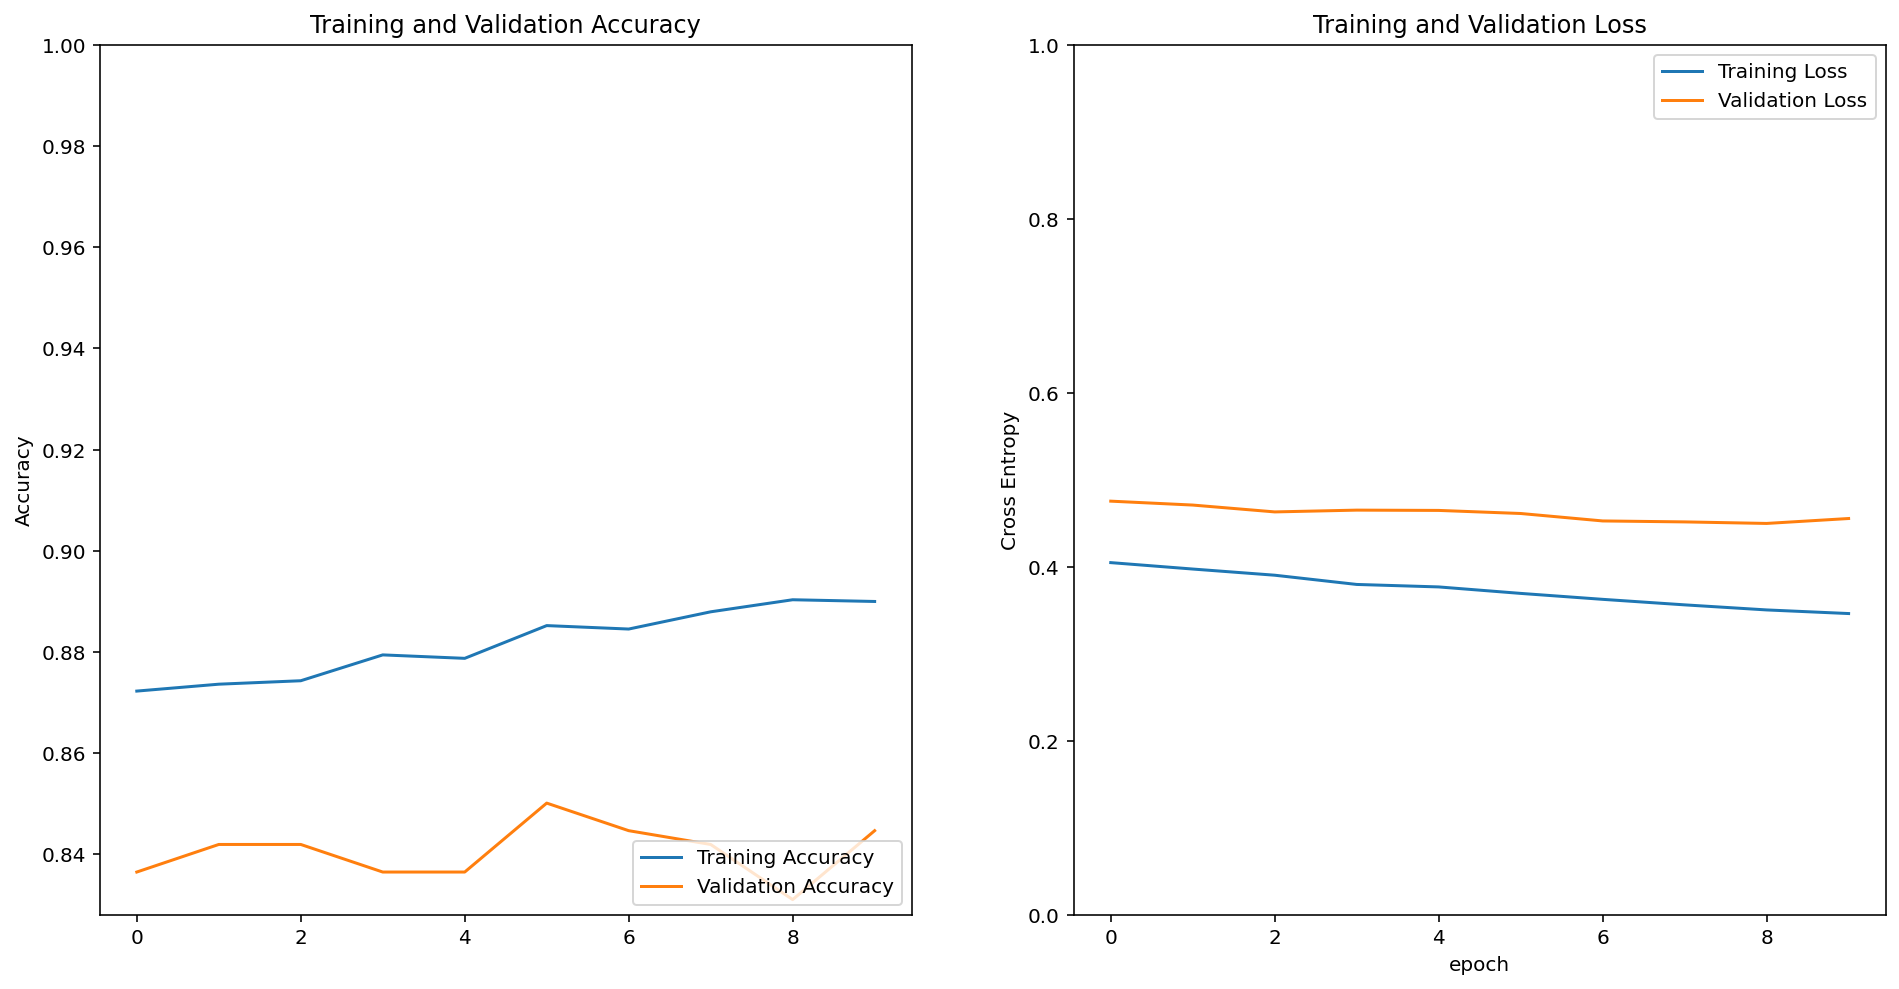

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    # [[YOUR CODE]]
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)    # 약 70% 내외

90.625


# 결론    
- 학습 모델에 따라 정확도가 달라진다.
- RMSProp 에 비해 Adam 의 학습모델 성능이 좋았다.
- epochs 를 늘리면 정확도가 향상된다.   
- 분류 함수로 클래스에 맞는 이미지들을 잘 분류 했다.   
- 클래스에 없는 꽃 들은 비슷한 모양으로 분류하는 것 같다.